In [106]:
import numpy as np
import math as mp
import pandas as pd

In [107]:
import numpy as np

def generate_pattern_array_with_extra_rows(tau):
    # 1) Create the original n×n pattern
    n = len(tau)+ int(np.min(tau))
    m = int(np.max(tau)) + int(np.min(tau))

    mx = int(max(tau))
    missing_count = len(set(range(int(max(tau) )+ 1)) - set(tau))
    print(missing_count)


    A = np.ones((m+2, n+missing_count), dtype=float)
    count = 0
    for i in range(1, m+2):
        for j in range(len(tau[tau == i-1])):
            A[i, n- i-j - count] = 0.95  # 0.9 shifts diagonally from right to left as we go down
        if len(tau[tau == i-1]) > 1:
            count += len(tau[tau == i-1])-1
    # 2) Create the two extra rows:
    #    (a) one row with 0.9 at the leftmost column,
    #    (b) one row of all ones.

    row_all_ones = np.ones(n+missing_count, dtype=float)
    A_extended = np.vstack([A,row_all_ones])
    A_extended = A_extended[:,0:n - int(np.min(tau))]

    return A_extended

In [133]:
# Some parameter initialization. 
sigma = 5
beta = 0.8
W = 1
n=np.linspace(1,0,2)

In [134]:
# Example usage:
A   = generate_pattern_array_with_extra_rows(n)
pd.DataFrame(A)

0


,0,1
0,1.00,1.00
1,1.00,0.95
2,0.95,1.00
3,1.00,1.00


In [151]:
tprod1 = beta**n* A[0,:]
# Solve for SS
PSS = (np.sum((1/(tprod1))**(1-sigma)))
y_ss = ((1/(tprod1))/PSS)**(-1/sigma) 
y_ss = np.sum(y_ss)/np.sum(y_ss) 


In [141]:
from scipy import optimize

def equilibrium_conditions(p_free, p_fixed, y_ss, beta_n, sigma):
    """Define equilibrium conditions that should be satisfied."""
    # Combine free and fixed prices
    p = np.concatenate([p_free, p_fixed])
    
    # Compute price index
    P = (np.sum(p**(1-sigma)))**(1/(1-sigma))
    
    # Compute profits using the free prices
    revenue = np.sum(p_free * beta_n[:len(p_free)] * y_ss[:len(p_free)])
    costs = np.sum(y_ss[:len(p_free)])
    profits = revenue - costs
    
    # Equilibrium conditions: price should equal marginal cost adjusted by markup
    target_prices = ((1 + profits))* np.sum(p**(1-sigma)) * y_ss[:len(p_free)]**(-1/sigma)
    
    # Return deviations from equilibrium
    return p_free - target_prices

# Initialize arrays for results
p_path = np.zeros((len(n)+1, int(np.max(n))+1))
p_path[0,:] = (1/(tprod1))
p_path[-1:] = (1/(tprod1))
nonge_profits = np.zeros((len(n)+1,))
nonge_profits[0] = 0

# Solve for each time step
for i in range(1, len(n)):
    # Get steady state prices for fixed portion
    p_ss = 1/(beta**n )* A[i,:]
    p_fixed = p_ss[-i:]
    
    # Initial guess for free prices (use ones)
    p_guess = np.ones(len(n) - i)
    
    try:
        # Solve the system using root finding
        result = optimize.root(
            lambda x: equilibrium_conditions(x, p_fixed, y_ss, beta**n, sigma),
            p_guess,
            method='hybr',
            options={'xtol': 1e-8, 'maxfev': 10000}
        )
        
        if result.success:
            # Construct full price vector
            p = np.concatenate([result.x, p_fixed])
            
            # Compute final profits
            revenue = np.sum(result.x * (beta**n)[:-i] * y_ss[:-i])
            costs = np.sum(y_ss[:-i])
            profits = revenue - costs
            
            nonge_profits[i] = profits
            p_path[i,:] = p
            
            print(f"Step {i} - Successfully converged")
            print(f"Profits: {profits:.6f}")
            print(f"Final prices: {p}\n")
        else:
            print(f"Step {i} - Failed to converge: {result.message}")
            # Use previous solution as fallback
            p_path[i,:] = p_path[i-1,:]
            nonge_profits[i] = nonge_profits[i-1]
            
    except Exception as e:
        print(f"Step {i} - Error occurred: {str(e)}")
        # Use previous solution as fallback
        p_path[i,:] = p_path[i-1,:]
        nonge_profits[i] = nonge_profits[i-1]

Step 1 - Successfully converged
Profits: 1.559937
Final prices: [3.15361881 0.95      ]



In [142]:
nonge_profits

array([0.        , 1.55993733, 0.        ])

In [143]:
1/(np.sum(p_path**(1-sigma),axis =1))**(1/(1-sigma))

array([1.08961726, 1.05479199, 1.08961726])

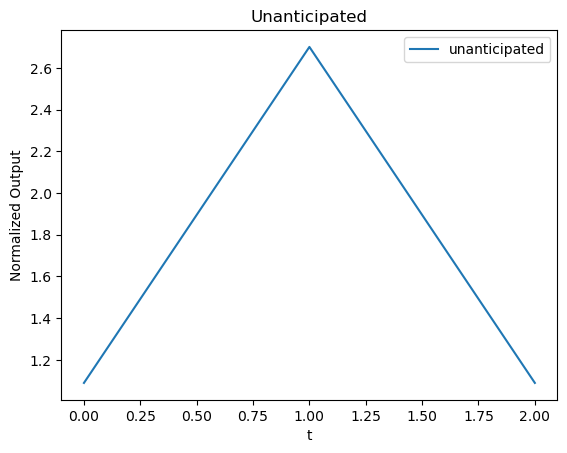

In [147]:
P0 = (np.sum(p_path**(1-sigma),axis =1))**(1/(1-sigma))
    
import matplotlib.pyplot as plt
plt.plot( ((1+nonge_profits)/P0), label='unanticipated')

plt.xlabel('t')
plt.ylabel('Normalized Output')
plt.title('Unanticipated')
plt.legend()
plt.show()